## Importing all the Libraries

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import Likelihood, QuantileRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

from datetime import timedelta
#warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Model

In [12]:
input_chunk_length = 50
output_chunk_length = 50  # Forecast horizon of 50 time steps

from pytorch_lightning.callbacks import Callback
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    # will automatically be called at the end of each epoch
    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))


loss_logger = LossLogger()

tft_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=128,
    n_epochs=50,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs={"callbacks": [loss_logger]},
)


tft_model = tft_model.load("/home/vnk3019/RCP_TFT_11202023_nn.pt")


## Importing and Loading Data

In [13]:
def estimate_cold_pressure(Pmeas,Tmeas,Tcold):
    Patm = 1.01325 #bar
    
    Pcold = (Pmeas + Patm)*(Tcold+273.15)/(Tmeas + 273.15) - Patm
    
    return Pcold

def gazao_rate_model(temperature,pressure,E = 6000, tau0 = 1/3, tire_sw = 275, tire_sh = 80, tire_rim = 22.5):
    R = 8.314e-2 #L*bar/(K*mol) ideal gas constant
    T0 = 293.15 #tempoerature in kelvin
    
    #estimating the approximate volume available in the tire
    Vtire = tire_sw*(((2*tire_sw*tire_sh/100 + tire_rim*25.4)**2)*np.pi/4 - ((tire_rim*25.4)**2)*np.pi/4)*1e-6 #liters
    
    T_K = temperature + 273.15
    gazao_rate = (1/tau0)*np.exp(-E/T_K)*24*3600*pressure # in bar per day lost by diffusion
    
    # estimating the loss of mol of gas per day 
    n_est = gazao_rate*Vtire/R/T0
    
    return n_est

def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load

def calc_nrg_from_classifier(clf,df,val_name):
    fts = [ 'P_avg_bar', 'avg_veh_speed_kph', 'wp_load_kg']
    df[val_name] = clf.predict(df[fts].values)    
    return df

example_df = pd.read_csv('Example_TimeSeries_Data_KR8833.bz2')

input_list = [x for x in list(example_df) if 'shear' not in x and 'nci' not in x and 'Insp_Damage' not in x]
output_list = [x for x in list(example_df) if x not in input_list]

# drum conditions 
Pinf_bar = 4.1
Load_kg = 1500
Speed_kph = 50
Start_Date = '2022-06-14'

tire_sn = 'AADB-0434'
study_type = 'DrumTesting_Condition5'

tire_type  = 'XLEZ 275/80R22.5'
#Time
freq_samp_hrs = 1 #sample per hour
rg_dates = pd.date_range(pd.to_datetime(Start_Date), pd.to_datetime(Start_Date) + timedelta(int(1e6/Speed_kph/24)),freq = str(freq_samp_hrs) + 'H')
test_df = pd.DataFrame(index = rg_dates)

# non-simulated data (although at this point temperature is estimated)

#age_days
test_df['age_days'] = (test_df.index - test_df.index[0])/timedelta(1)
#avg_speed_kph
test_df['avg_veh_speed_kph'] = Speed_kph
#casing_mileage_kms
test_df['delta_casing_mileage_kms'] = test_df.avg_veh_speed_kph*freq_samp_hrs
test_df['casing_mileage_kms'] = test_df.delta_casing_mileage_kms.cumsum()
#life_num
test_df['Life_Num'] = 1
#POS
test_df['POS'] = '1L'
#wp_load_kg
test_df['wp_load_kg'] = Load_kg
#P_avg_bar
test_df['P_avg_bar'] = Pinf_bar
#T_avg_degC
test_df['T_avg_degC'] = 50

#gazao modeling
test_df['n_rxns_per_hr'] = gazao_rate_model(test_df.T_avg_degC,test_df.P_avg_bar)/24
test_df['n_rxns_cumul'] = test_df.n_rxns_per_hr.cumsum()

#fill in the FEA metrics
rolling_radius = 498.2 #mm, simulation average among all conditions with little variation (taken from XLEZ)
Nrev_per_km = 1/(np.pi*2*rolling_radius*1e-6)
daNmm_to_kilajoule = 1e-5
clf_list = [x for x in os.listdir('./') if 'XLEZ' in x and 'NC_sidewall' in x]
clfs = [joblib.load('./' + x) for x in clf_list]
clf_name = ['_'.join(x.split('_')[1:5]) for x in clf_list]

for clf,clname in zip(clfs,clf_name):
    test_df = calc_nrg_from_classifier(clf,test_df,clname)
    if clname == 'NC_sidewall_SEelm_sumrev':
        #do a summamtion across the number of revolutions and the energy calculated, then convert the energy estimated to kilajoules
        test_df[clname] = (test_df[clname]*Nrev_per_km*test_df['avg_veh_speed_kph']*daNmm_to_kilajoule).cumsum()
test_df['Time'] = test_df.index
test_df.reset_index(drop = True, inplace = True)

In [14]:
def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load


In [15]:
data = pd.read_csv("/home/vnk3019/Gaussian_Reduced_Data.csv")
data = data[data['Tire_ID']=='STX01']
data

,age_days,casing_mileage_kms,Life_Num,wp_load_kg,avg_veh_speed_kph,P_avg_bar,T_avg_degC,n_rxns_cumul,NC_sidewall_SEelm_sumrev,NC_sidewall_CVMD_AMP,NC_sidewall_maxCVMD_rev,predicted_RCP,Tire_ID
94464,-1.946798e-11,-2.381512e-08,1.0,2774.198264,92.292647,8.104516,30.362504,-0.003727,0.034646,0.005307,-0.010215,1.0,STX01
94465,7.537879e-01,9.225030e+02,1.0,2774.198264,96.633881,8.132641,31.509526,0.035728,2.399216,0.005262,-0.010207,1.0,STX01
94466,1.507576e+00,1.845006e+03,1.0,2774.198264,99.375608,8.134874,32.103528,0.073938,4.781447,0.005243,-0.010202,1.0,STX01
94467,2.261364e+00,2.767509e+03,1.0,2774.198264,100.819534,8.117553,32.263808,0.111058,7.178996,0.005243,-0.010199,1.0,STX01
94468,3.015152e+00,3.690012e+03,1.0,2774.198264,101.267369,8.087016,32.109662,0.147242,9.589520,0.005256,-0.010198,1.0,STX01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94603,1.036985e+03,5.809693e+05,2.0,1433.533497,100.000000,7.088238,28.239076,18.345957,1394.560087,0.004147,-0.010228,0.0,STX01
94604,1.037739e+03,5.817975e+05,2.0,1433.533497,100.000000,7.100940,28.503606,18.370075,1395.972147,0.004130,-0.010228,0.0,STX01
94605,1.038492e+03,5.826258e+05,2.0,1433.533497,100.000000,7.128110,29.043486,18.394368,1397.383540,0.004090,-0.010228,0.0,STX01
94606,1.039246e+03,5.834540e+05,2.0,1433.533497,100.000000,7.173065,29.913009,18.418895,1398.794042,0.004022,-0.010229,0.0,STX01


In [16]:
tire_data = data[['age_days', 'avg_veh_speed_kph', 
       'casing_mileage_kms', 'Life_Num', 'wp_load_kg', 'P_avg_bar',
       'T_avg_degC', 'n_rxns_cumul']]
tire_data['P_avg_bar'] = 7
tire_data['T_avg_degC'] = 35
tire_data['avg_veh_speed_kph'] = 100


# Define a function to apply to the 'casing_mileage_kms' to determine 'Life_Num'
def assign_life_num(mileage):
    if 0 <= mileage <= 250000:
        return 1
    elif 250000 < mileage <= 500000:
        return 2
    else:
        return 3  # Or some other value for mileages outside the specified range

tire_data['Life_Num'] = tire_data['casing_mileage_kms'].apply(assign_life_num)


tire_data

,age_days,avg_veh_speed_kph,casing_mileage_kms,Life_Num,wp_load_kg,P_avg_bar,T_avg_degC,n_rxns_cumul
94464,-1.946798e-11,100,-2.381512e-08,3,2774.198264,7,35,-0.003727
94465,7.537879e-01,100,9.225030e+02,1,2774.198264,7,35,0.035728
94466,1.507576e+00,100,1.845006e+03,1,2774.198264,7,35,0.073938
94467,2.261364e+00,100,2.767509e+03,1,2774.198264,7,35,0.111058
94468,3.015152e+00,100,3.690012e+03,1,2774.198264,7,35,0.147242
...,...,...,...,...,...,...,...,...
94603,1.036985e+03,100,5.809693e+05,3,1433.533497,7,35,18.345957
94604,1.037739e+03,100,5.817975e+05,3,1433.533497,7,35,18.370075
94605,1.038492e+03,100,5.826258e+05,3,1433.533497,7,35,18.394368
94606,1.039246e+03,100,5.834540e+05,3,1433.533497,7,35,18.418895


## Surrogate FEM model to find Energy state and internal energy 

In [17]:
# The function that encapsulates the modeling process
def perform_modeling(df):
    # Applying the gazao_rate_model
    df['n_rxns_per_hr'] = gazao_rate_model(df.T_avg_degC, df.P_avg_bar) / 24
    df['n_rxns_cumul'] = df.n_rxns_per_hr.cumsum()

    # Constants
    rolling_radius = 498.2  # mm, simulation average among all conditions
    Nrev_per_km = 1 / (np.pi * 2 * rolling_radius * 1e-6)
    daNmm_to_kilajoule = 1e-5

    # Placeholder for actual classifier files and joblib loading process.
    clf_list = [x for x in os.listdir('./') if 'XLEZ' in x and 'NC_sidewall' in x]
    clfs = [joblib.load('./' + x) for x in clf_list]
    clf_name = ['_'.join(x.split('_')[1:5]) for x in clf_list]

    # Calculating energy from classifiers
    for clf, clname in zip(clfs, clf_name):
        df = calc_nrg_from_classifier(clf, df, clname)
        if clname == 'NC_sidewall_SEelm_sumrev':
            # Summation across the number of revolutions and the energy calculated, convert to kilajoules
            df[clname] = (df[clname] * Nrev_per_km * df['avg_veh_speed_kph'] * daNmm_to_kilajoule).cumsum() *45

    # Setting 'Time' column to be the index of the DataFrame
    df['Time'] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [18]:
# Function to change tire location based on mileage and location
def change_tire_location(df, total_load, start_mileage, end_mileage, perform_modeling, new_location):
    # Selecting the rows where tire needs to be changed based on the mileage
    df_to_change = df[(df['casing_mileage_kms'] >= start_mileage) & (df['casing_mileage_kms'] <= end_mileage)]
    
    # Change the tire location for selected rows
    df.loc[df_to_change.index, 'wp_load_kg'] = repartition_static_load(total_load, WP = new_location,mount_type = 'dual')

    df = perform_modeling(df)
    index = df_to_change.index[-1]
    
    return df, index

# Assuming we have to change tire location from '1L' to '2L' between 200 and 250 kms
tire_data_changed_1 = change_tire_location(tire_data, 36000, start_mileage=0, end_mileage=1000000, perform_modeling = perform_modeling, new_location='4L0')

In [19]:
# Function to change tire location and perform time series forecasting
def change_location_and_forecast(df, total_load, start_mileage, end_mileage, new_location, tft_model, RCP_start = 1):
    # Change tire location based on mileage and perform modeling
    df, index = change_tire_location(df, total_load, start_mileage, end_mileage, perform_modeling, new_location)
    
    # Prepare the DataFrame for forecasting
    df_rcp_cov = df[['Life_Num', 'NC_sidewall_CVMD_AMP', 'NC_sidewall_SEelm_sumrev',
                     'NC_sidewall_maxCVMD_rev', 'P_avg_bar', 'T_avg_degC', 'age_days',
                     'avg_veh_speed_kph', 'casing_mileage_kms', 'n_rxns_cumul',
                     'wp_load_kg']]

    
    # Create a DataFrame for the series
    df_rcp_ser = pd.DataFrame({'Column1': [RCP_start] * 50})
    
    # Convert DataFrames to TimeSeries objects
    darts_rcp_cov = TimeSeries.from_dataframe(df_rcp_cov).astype(np.float32)
    darts_rcp_ser = TimeSeries.from_dataframe(df_rcp_ser).astype(np.float32)
    
    # Forecast using the pre-trained model
    Remaining_RCP = tft_model.predict(n=darts_rcp_cov.time_index.stop-100, series=darts_rcp_ser, future_covariates=darts_rcp_cov, num_samples=50, verbose=False)
    
    return Remaining_RCP[index].values()

# Correct function call
RCP = change_location_and_forecast(tire_data, 36000, 0, 300000, '1LO', tft_model)
float(RCP)

0.18439994752407074

In [20]:
x = np.linspace(1000, 300000, 5)
RCP_reduction_list = []

for end_dist in tqdm(x):
    end_dist_value = int(end_dist)
    RCP = change_location_and_forecast(tire_data, 36000, 0, end_dist_value, '2LO', tft_model)
    RCP_reduction_list.append(float(RCP))


  0%|          | 0/5 [00:00<?, ?it/s]

Mileage Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Mileage Steps: 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


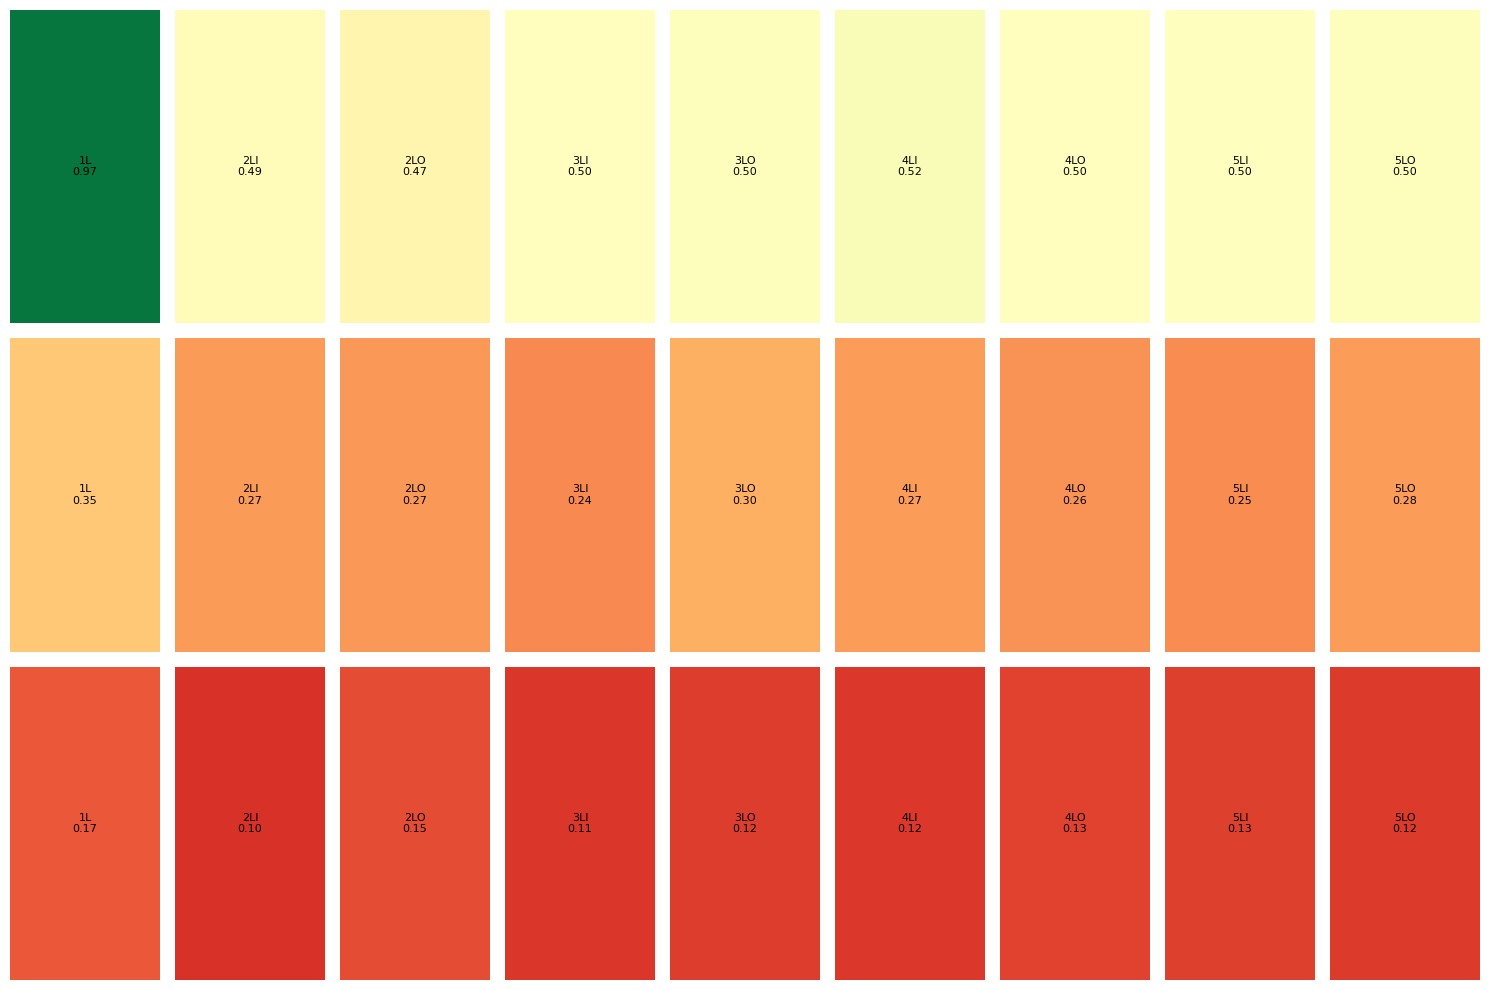

In [30]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define tire locations
tire_locations = ['1L', '2LI', '2LO', '3LI', '3LO', '4LI', '4LO', '5LI', '5LO']

# Mileage steps from 100 to 100000 with 5 steps
mileage_steps = np.linspace(1000, 300000, 3)

# Initialize a DataFrame to store RCP predictions with an extra 'Mileage' column
columns = ['Mileage'] + tire_locations
rcp_predictions = pd.DataFrame(columns=columns)

# Iterate over each mileage step and each tire location
for end_mileage in tqdm(mileage_steps, desc="Mileage Steps"):
    rcp_row = {'Mileage': end_mileage}
    for location in tire_locations:

        # Adjust RCP_start based on location
        RCP_start = 1 if location == '1L' else 0.5

        # Call the forecasting function for each combination of location and mileage step
        RCP = change_location_and_forecast(tire_data, 16000, 0, int(end_mileage), location, tft_model, RCP_start=RCP_start)
        
        # Assuming RCP returns a numeric value or an object from which a numeric value can be extracted
        rcp_row[location] = float(RCP)  # Replace RCP with the appropriate value extraction if necessary
    
    # Append the row to the DataFrame
    rcp_predictions = rcp_predictions.append(rcp_row, ignore_index=True)

# Display the resulting DataFrame
data_dict = rcp_predictions.set_index('Mileage').T.to_dict('list')
data_dict

# Convert the provided dictionary to the desired dictionary format
data = {"Mileage": list(data_dict.keys())}
for i, loc in enumerate(tire_locations):
    data[loc] = [values[i] for values in data_dict.values()]

# Now, `data` is in the desired format
import matplotlib.pyplot as plt
import numpy as np

# Assuming data has been provided in the same structure as before.

# Normalize the values to map to the colormap
norm = plt.Normalize(0, 1)
mapper = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn')

# Setting up the figure and axes
fig, axs = plt.subplots(len(data['Mileage']), len(data) - 1, figsize=(15, 10))

# Loop through each mileage step
for i, mileage in enumerate(data['Mileage']):
    for j, (location, values) in enumerate(data.items()):
        if location == 'Mileage':
            continue  # Skip the mileage column
        
        # Get the value corresponding to the current mileage step
        val = values[i]
        
        # Get the color from the color map
        color = mapper.to_rgba(val)
        
        # Plot the colored cell
        axs[i, j - 1].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
        axs[i, j - 1].text(0.5, 0.5, f'{location}\n{val:.2f}', ha='center', va='center', fontsize=8, color='black')
        
        # Turn off the axis
        axs[i, j - 1].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


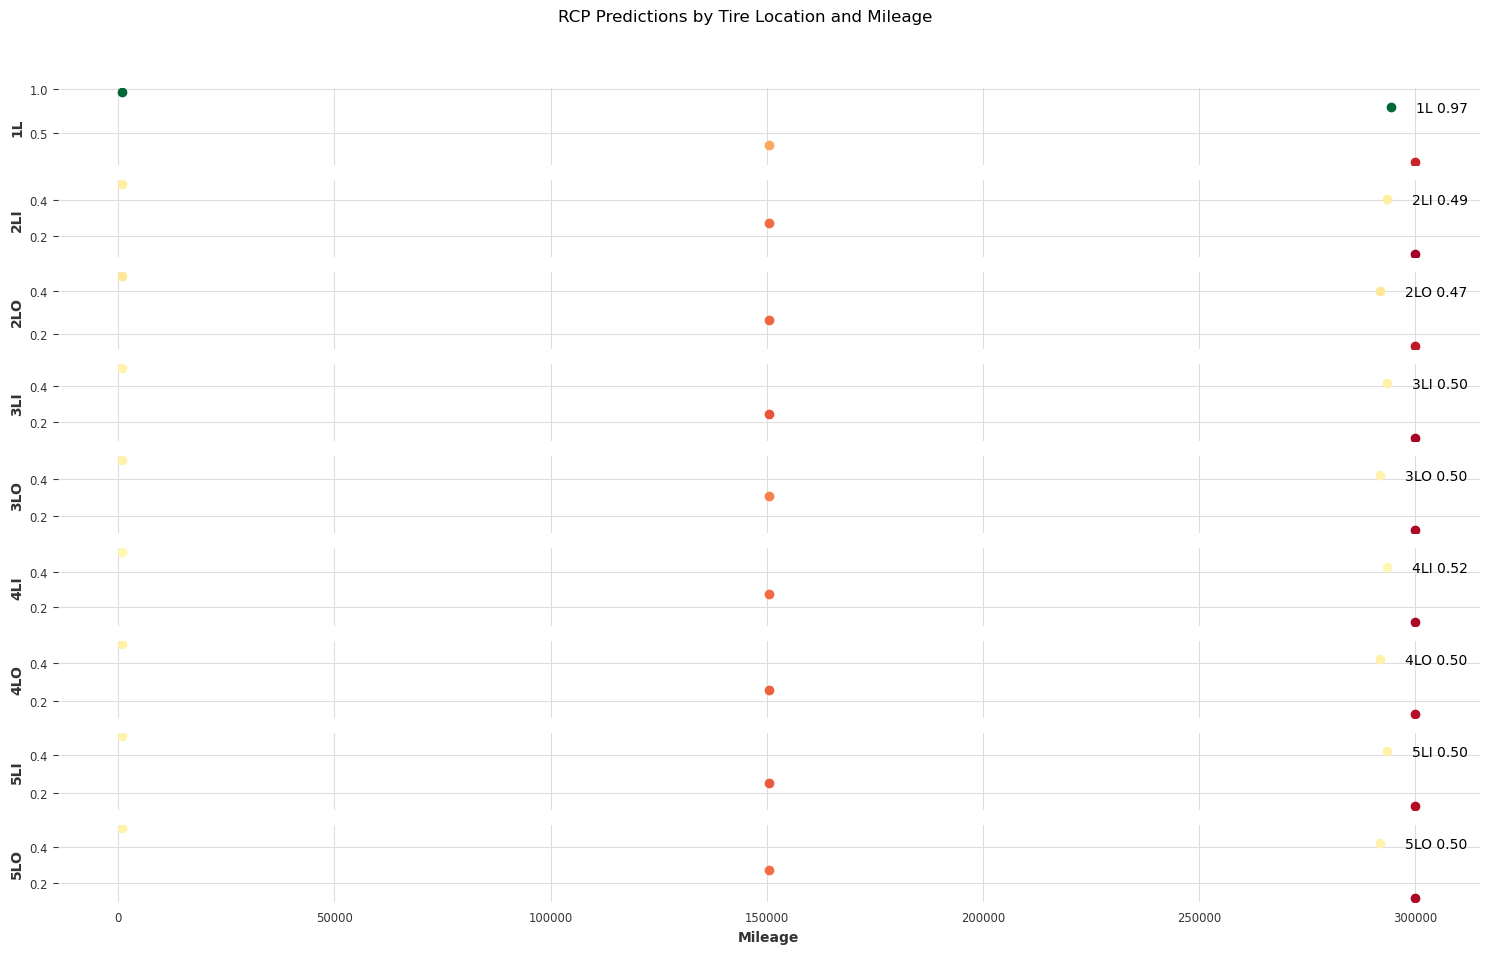

In [32]:
# Normalize the RCP values to map to the colormap
norm = plt.Normalize(rcp_predictions[tire_locations].min().min(), rcp_predictions[tire_locations].max().max())
mapper = plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn')

# Setting up the figure
fig, axs = plt.subplots(len(tire_locations), 1, figsize=(15, 10), sharex=True)

# Loop through each tire location
for j, location in enumerate(tire_locations):
    # Get the RCP values for the current location across all mileage steps
    values = rcp_predictions[location]
    
    # Plotting each mileage step value as a colored line segment or marker
    for i, val in enumerate(values):
        color = mapper.to_rgba(val)
        axs[j].plot(rcp_predictions['Mileage'][i], val, 'o', color=color, label=f'{location} {val:.2f}' if i == 0 else "")
        
    axs[j].set_ylabel(location)
    axs[j].legend()

# Set common labels
plt.xlabel('Mileage')
plt.suptitle('RCP Predictions by Tire Location and Mileage')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make room for the suptitle

# Show the plot
plt.show()

## Two different trucks

In [23]:
total_load_truck_1 = 16000
total_load_truck_2 = 36000

change_location_and_forecast(tire_data, total_load_truck_1, 0, int(end_mileage), location, tft_model)


array([[0.48951843]], dtype=float32)